# Interprétabilité du modèle d'entrainement sur le prix au m² des maisons

Dans ce Notebook, on va interpréter le modèle d'entrainement Gradient Boosting Regressor qui nous permet de determiner le prix d'une maison dans l'Essonne.

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve, auc
import shap
from sklearn.ensemble import RandomForestRegressor
import joblib

from IPython.display import display
%matplotlib inline

Chargement du dataframe des maisons vendues en 2022 dans le 91 (triée précedement dans le notebook *Entrainement sur les maisons du 91* )

In [9]:
df_maisons = pd.read_csv(r"../data/df_maisons_trait_2022_91.csv")
df_maisons.head()

,date_mutation,nb_elements,valeur_fonciere,code_commune,nom_commune,surface_reelle_bati,somme_terrain,local_dependance,local_terrain,nombre_pieces_principales,l_code_nature_culture,l_code_nature_culture_speciale,prix_mcarr_moy_ville,prix_m_carre
0,2022-07-28,1,258000.0,91016,Angerville,57.0,461.0,0,0,3.0,{'S'},{'PDCS'},2276.423158,4526.315789
1,2022-11-25,1,256000.0,91016,Angerville,97.0,315.0,0,0,5.0,{'S'},{'PDCS'},2276.423158,2639.175258
2,2022-03-08,1,210000.0,91016,Angerville,95.0,332.0,0,0,4.0,{'S'},{'PDCS'},2276.423158,2210.526316
3,2022-03-08,2,207000.0,91016,Angerville,75.0,483.0,1,0,3.0,{'S'},{'PDCS'},2276.423158,2760.000000
4,2022-04-05,1,230000.0,91016,Angerville,92.0,411.0,0,0,4.0,{'S'},{'PDCS'},2276.423158,2500.000000


Séparation de la variable cible et des features, puis d'un jeu d'entrainement et de test  

In [3]:
data = df_maisons[['surface_reelle_bati', 'nombre_pieces_principales', 'somme_terrain', 'code_commune', 'prix_mcarr_moy_ville']]
target = df_maisons['prix_m_carre']

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=101)

Entrainement du modèle avec les hyperparamètres optimaux trouvés dans le précédent Notebook 

In [7]:
model = RandomForestRegressor(random_state=42, 
                              max_depth = 10,
                              min_samples_leaf = 2,
                              min_samples_split = 10, 
                              n_estimators = 200)

#{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

training_history = model.fit(X_train, y_train)

joblib.dump(model, "../model/modelRFRMaisons")

y_pred = model.predict(X_test)


percentage_errors = (y_test - y_pred) / y_test
mape = np.mean(np.abs(percentage_errors)) * 100  

#Affichage de la MAPE
print(f"MAPE: {mape}%")

MAPE: 15.177851955033631%


Affichage d'un diagramme en barre, qui permet de connaître les variables qui ont le plus de poids sur l'estimation du bien

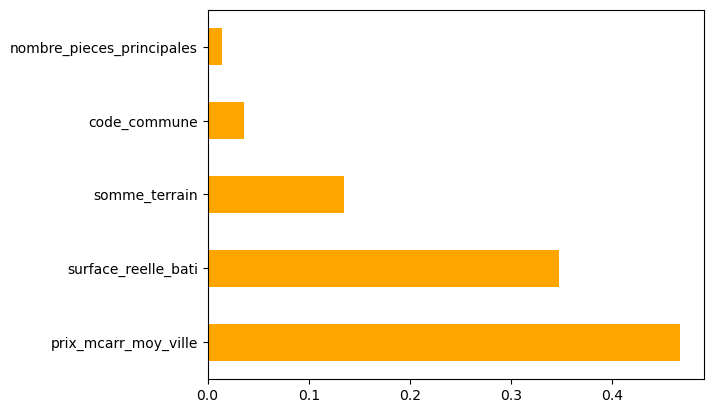

In [8]:
feat_importances = pd.Series(
    model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh', color = 'orange');

Utilisation de Shap pour connaître les coefficients de chaque variable et leur contribution

In [7]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test)

print('Expected Value:', explainer.expected_value)

pd.DataFrame(shap_values).head()

Expected Value: [3878.77020748]


,0,1,2,3,4
0,214.117622,-10.918496,-318.082713,-0.658974,-819.075634
1,1366.612940,-7.371758,-605.348335,30.583671,-473.002078
2,388.698289,1.873929,163.179041,-1.723819,-410.989157
3,387.546867,2.649498,46.068718,-1.369424,-550.141417
4,-865.774639,-5.839286,-3.854101,-1.440830,363.747478


Affichage d'un diagramme en barre, qui permet de connaître les variables qui ont le plus de poids sur l'estimation du bien

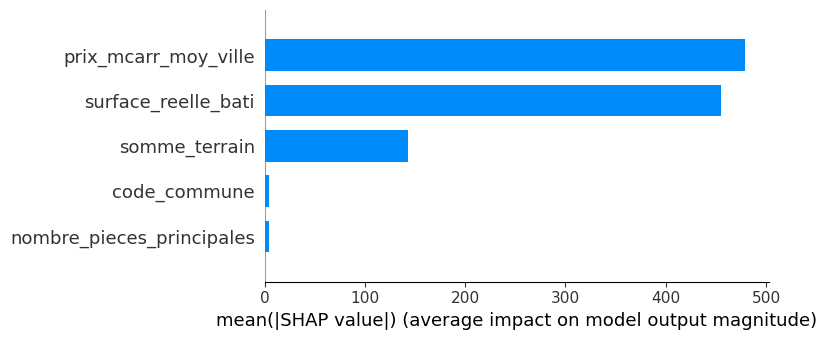

In [8]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Sur ce graphique en barre, on remarque que le prix au m² moyen par ville est la variable qui a le plus de poids sur le prix moyen au m², on remarque aussi que la surface reelle du batiment a aussi un poids élevé.


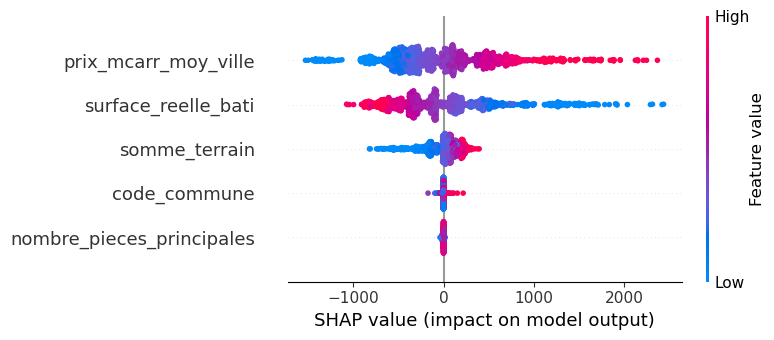

In [9]:
shap.summary_plot(shap_values, X_test)

Sur celui-ci, on observe la densité des variables et leur impact sur le modèle. 

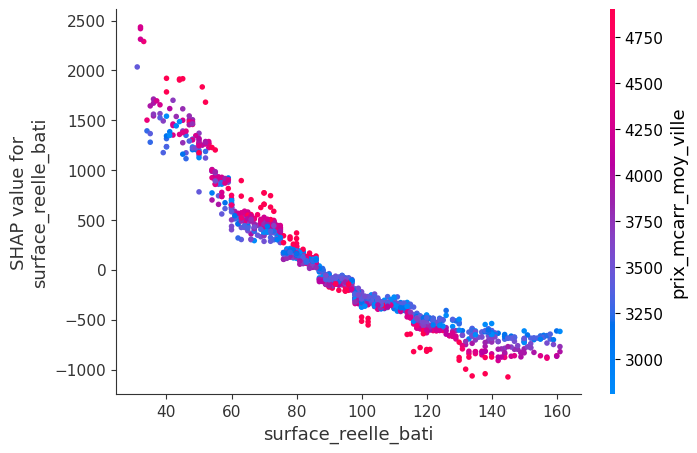

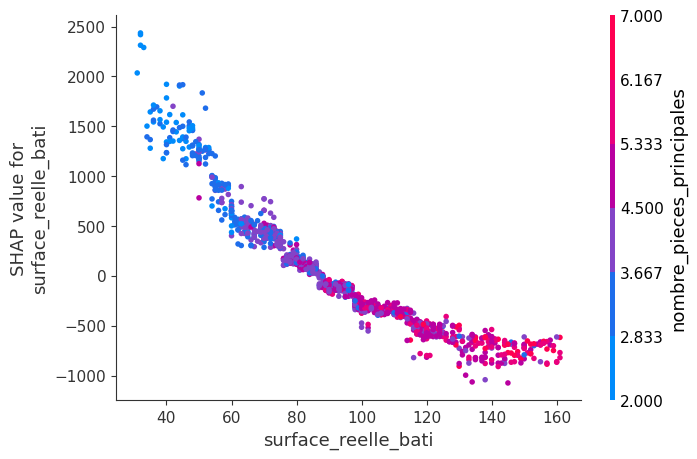

In [16]:
shap.dependence_plot("surface_reelle_bati", shap_values, X_test, interaction_index= "prix_mcarr_moy_ville")

shap.dependence_plot("surface_reelle_bati", shap_values, X_test, interaction_index= "nombre_pieces_principales")

Ici, on étudie la dépendance de chaque variable avec son coefficient SHAP, et sa répartition selon une autre variable.

In [17]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[3,:], X_test.iloc[3,:])

shap.force_plot(explainer.expected_value, shap_values[103,:], X_test.iloc[103,:])

Ici, pour une estimation, on voit le poid qu'à eu chaque variable dans l'estimation du prix.

In [12]:
shap.force_plot(explainer.expected_value, shap_values[:1000], X_test[:1000])

Un autre graphique pour parler de l'interprétabilité, mais plus difficile à lire.

## Conclusion

Pour conclure ce Notebook, on voit que certaines variables choisies pour ce modèle ont un poid très important dans la décision de l'estimation. Il faudrait trouver d'autres variables qui puissent avoir ce même poids. Cordonnées géographiques, Infrastuctures, indice DPE...